Partie 2 : Feature Engineering
================================

Objectifs
---------
- Créer des features utilisateurs pertinentes
- Créer des features produits
- Créer des features d'interactions
- Normaliser et encoder les données


In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import SimpleImputer
warnings.filterwarnings('ignore')

sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)


Chargement des Données
----------------------

Chargez les données que vous avez explorées dans le notebook précédent.


In [7]:
# TODO : Charger les données
DATA_PATH = "../data/"

users_df = pd.read_csv(DATA_PATH + 'users.csv')
products_df = pd.read_csv(DATA_PATH + 'products.csv')
interactions_df = pd.read_csv(DATA_PATH + 'interactions.csv')

# Conversion des dates
users_df['registration_date'] = pd.to_datetime(users_df['registration_date'])
products_df['added_date'] = pd.to_datetime(products_df['added_date'])
interactions_df['interaction_date'] = pd.to_datetime(interactions_df['interaction_date'])

print("Données chargées avec succès")


Données chargées avec succès


2.1 - Features Utilisateurs
----------------------------

Créez les features suivantes pour chaque utilisateur :
- Niveau d'activité (nombre d'interactions)
- Panier moyen
- Catégorie préférée
- Ancienneté de la dernière activité


In [8]:
# TODO : Créer les features utilisateurs

user_activity = interactions_df.groupby('user_id').size().reset_index(name='activity')


user_avg_price = (
    interactions_df
    .merge(products_df[['product_id', 'price']], on='product_id', how='left')
    .groupby('user_id')['price']
    .mean()
    .reset_index(name='avg_price')
)


user_favorite_category = (
    interactions_df
    .merge(products_df[['product_id', 'category']], on='product_id', how='left')
    .groupby('user_id')['category']
    .agg(lambda x: x.value_counts().idxmax())
    .reset_index(name='favorite_category')
)


last_dates = interactions_df.groupby('user_id')['interaction_date'].max().reset_index(name='last_interaction')
current_date = interactions_df['interaction_date'].max()
last_dates['days_since_last'] = (current_date - last_dates['last_interaction']).dt.days
user_days_since_last = last_dates[['user_id', 'days_since_last']]

users_features = users_df.copy()
users_features = (
    users_features
    .merge(user_activity, on='user_id', how='left')
    .merge(user_avg_price, on='user_id', how='left')
    .merge(user_favorite_category, on='user_id', how='left')
    .merge(user_days_since_last, on='user_id', how='left')
)

print(f"Features utilisateurs créées : {users_features.shape}")
users_features.head()

Features utilisateurs créées : (5000, 10)


,user_id,age,gender,location,registration_date,activity_level,activity,avg_price,favorite_category,days_since_last
0,1,33,M,69,2025-08-20 10:25:45.743084,2,9.0,1291.320000,Ordinateurs,16.0
1,2,28,M,75,2024-02-27 10:25:45.743084,2,5.0,262.958000,Tablettes,85.0
2,3,35,M,67,2023-11-30 10:25:45.743084,2,6.0,1217.290000,Gaming,17.0
3,4,42,M,31,2024-08-12 10:25:45.743084,2,7.0,565.297143,Audio,9.0
4,5,28,M,69,2024-07-12 10:25:45.743084,1,1.0,2609.630000,Ordinateurs,353.0


2.2 - Features Produits
------------------------

Créez les features suivantes pour chaque produit :
- Popularité (nombre d'interactions)
- Taux de conversion (achats/vues)
- Note moyenne
- Gamme de prix (low/mid/high)


In [9]:
# TODO : Créer les features produits

product_popularity = interactions_df.groupby('product_id').size().reset_index(name='popularity')

product_conversion = (
    interactions_df.groupby('product_id')['interaction_type']
    .apply(lambda x: (x == 'purchase').sum() / len(x) if len(x) > 0 else 0)
    .reset_index(name='conversion_rate')
)

product_avg_rating = interactions_df.groupby('product_id')['rating'].mean().reset_index(name='avg_rating')

def categorize_price(price):
    if price < 20:
        return 'low'
    elif price < 50:
        return 'medium'
    elif price < 100:
        return 'high'
    else:
        return 'premium'

products_df['price_range'] = products_df['price'].apply(categorize_price)

products_features = products_df.copy()
products_features = (
    products_features
    .merge(product_popularity, on='product_id', how='left')
    .merge(product_conversion, on='product_id', how='left')
    .merge(product_avg_rating, on='product_id', how='left')
)

print(f"Features produits créées : {products_features.shape}")
products_features.head()


Features produits créées : (1000, 13)


,product_id,name,category,subcategory,price,stock,initial_rating,added_date,description,price_range,popularity,conversion_rate,avg_rating
0,1,Dell Photo Appareil Photo Standard,Photo,Appareil Photo,4526.99,190,3.7,2025-08-26 10:25:45.743084,Performant Dell Photo Appareil Photo Standard....,premium,57,0.070175,4.000000
1,2,Xiaomi Ordinateurs Laptop Plus,Ordinateurs,Laptop,895.93,217,4.2,2024-07-12 10:25:45.743084,Élégant Xiaomi Ordinateurs Laptop Plus. Connec...,premium,44,0.113636,3.400000
2,3,Sony Ordinateurs Desktop Pro,Ordinateurs,Desktop,2786.19,428,5.0,2023-12-04 10:25:45.743084,Performant Sony Ordinateurs Desktop Pro. Desig...,premium,45,0.066667,4.333333
3,4,Lenovo Accessoires Cable Pro,Accessoires,Cable,176.90,153,3.7,2024-03-06 10:25:45.743084,Puissant Lenovo Accessoires Cable Pro. Design ...,premium,49,0.040816,3.333333
4,5,Asus Smartphones iPhone Pro,Smartphones,iPhone,690.03,276,4.9,2024-08-14 10:25:45.743084,Premium Asus Smartphones iPhone Pro. Design mo...,premium,55,0.090909,4.500000


2.3 - Normalisation et Encodage
---------------------------------

Normalisez les features numériques et encodez les features catégorielles.


In [11]:
# TODO : Normalisation et encodage

num_features_users = ['age', 'activity_level', 'avg_price', 'days_since_last']
num_features_products = ['price', 'popularity', 'conversion_rate', 'avg_rating']

scaler = StandardScaler()

users_features[num_features_users] = scaler.fit_transform(users_features[num_features_users])

products_features[num_features_products] = scaler.fit_transform(products_features[num_features_products])


categorical_features_users = ['gender', 'favorite_category']
categorical_features_products = ['price_range', 'category', 'subcategory']

label_encoders = {}

for col in categorical_features_users:
    le = LabelEncoder()
    users_features[col] = le.fit_transform(users_features[col].astype(str))
    label_encoders[col] = le

for col in categorical_features_products:
    le = LabelEncoder()
    products_features[col] = le.fit_transform(products_features[col].astype(str))
    label_encoders[col] = le

print("Normalisation et encodage terminés")


Normalisation et encodage terminés


2.4 - Analyse de Corrélation
-----------------------------

Analysez les corrélations entre les différentes features.


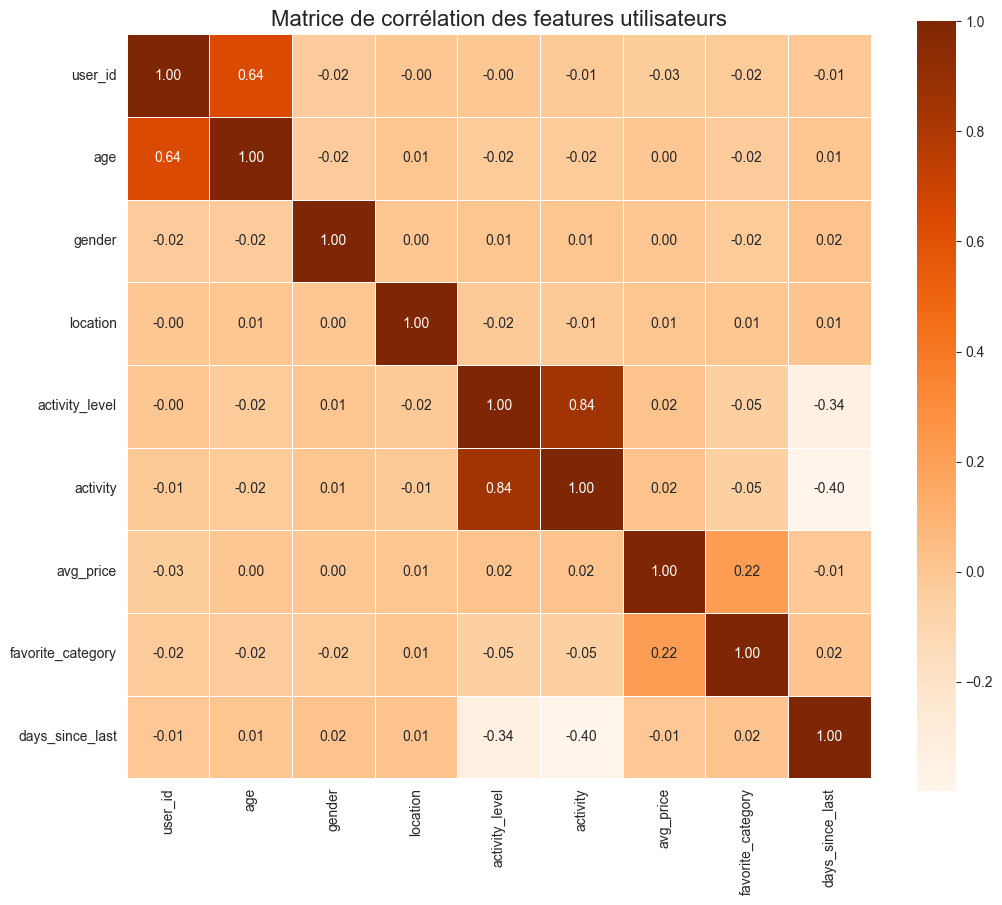

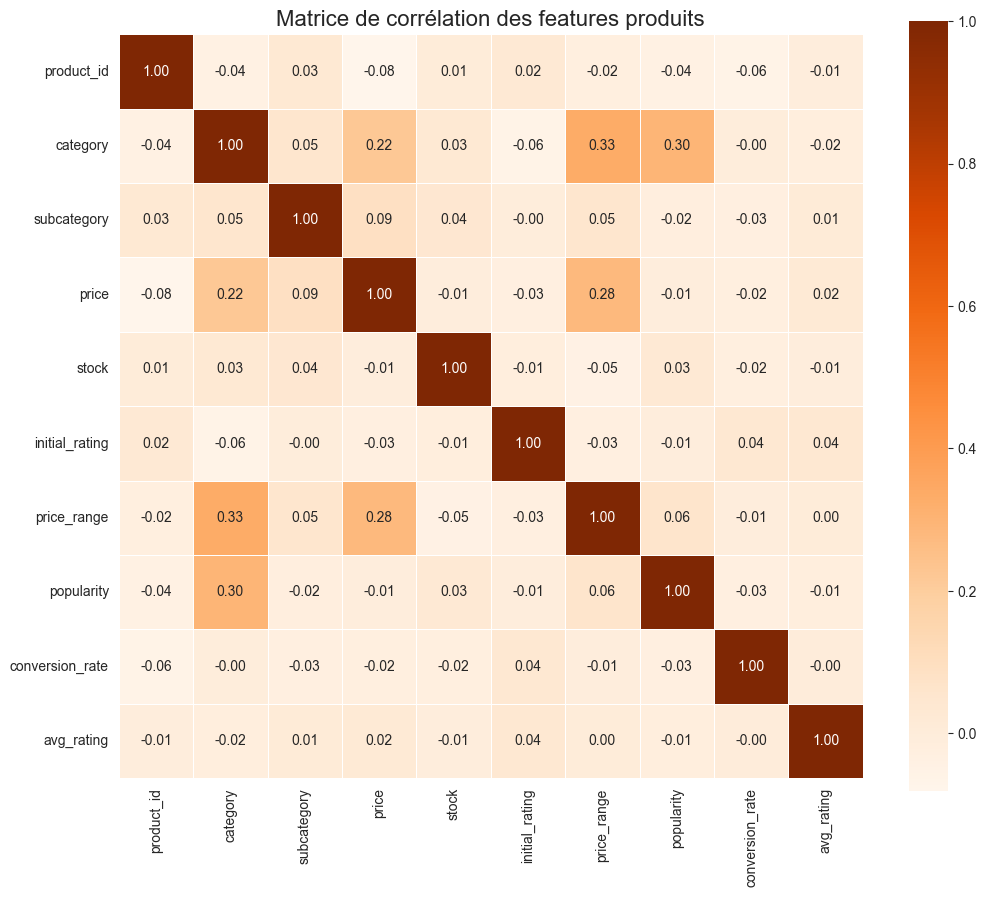

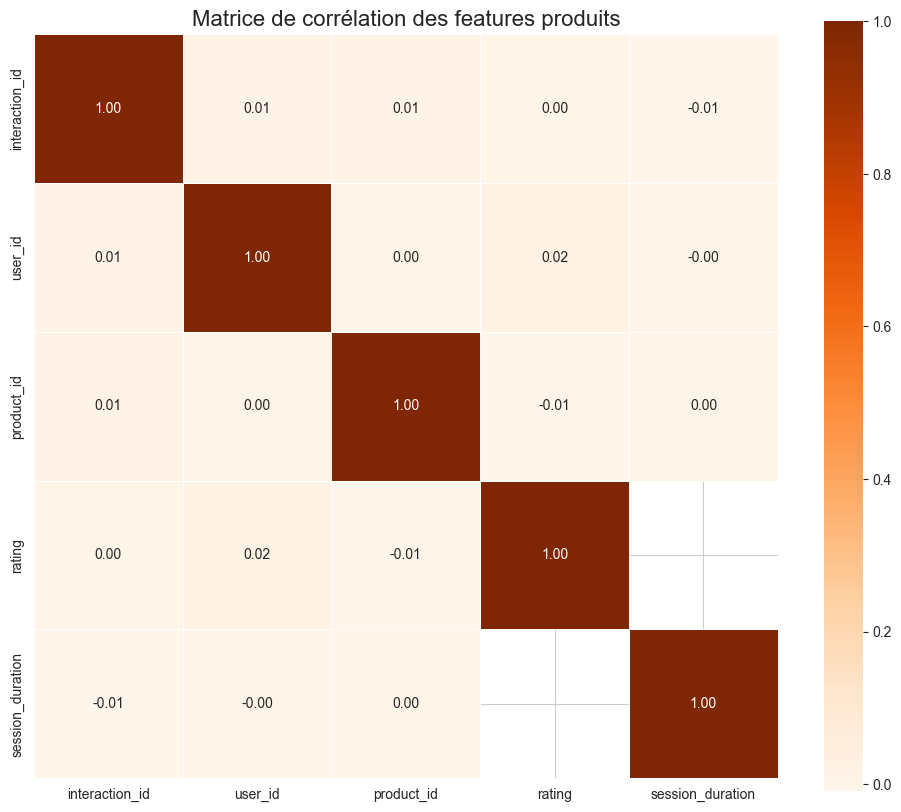

In [36]:
# TODO : Matrice de corrélation

corr_matrix_user = users_features.select_dtypes(include='number').corr()

plt.figure(figsize=(12, 10))
sns.heatmap(
    corr_matrix_user, 
    annot=True,
    fmt=".2f",
    cmap="Oranges",
    linewidths=0.5,
    square=True
)
plt.title("Matrice de corrélation des features utilisateurs", fontsize=16)
plt.show()




corr_matrix_products = products_features.select_dtypes(include='number').corr()

plt.figure(figsize=(12, 10))
sns.heatmap(
    corr_matrix_products, 
    annot=True,
    fmt=".2f",
    cmap="Oranges",
    linewidths=0.5,
    square=True
)
plt.title("Matrice de corrélation des features produits", fontsize=16)
plt.show()




corr_matrix_inters = interactions_df.select_dtypes(include='number').corr()

plt.figure(figsize=(12, 10))
sns.heatmap(
    corr_matrix_inters, 
    annot=True,
    fmt=".2f",
    cmap="Oranges",
    linewidths=0.5,
    square=True
)
plt.title("Matrice de corrélation des features produits", fontsize=16)
plt.show()

*enregistrement des df avec les features*

In [37]:
users_features.to_csv(DATA_PATH + 'users_features.csv', index=False)

products_features.to_csv(DATA_PATH + 'products_features.csv', index=False)

print("DataFrames enregistrés avec succès !")

DataFrames enregistrés avec succès !


Prochaines Étapes
-----------------

Maintenant que les features sont créées, passez au notebook 03_Modeling_starter.ipynb pour implémenter les modèles de recommandation.
